# Chapter 17: Recommending Books using LightGCN

In [2]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Exploring the Book-Crossing dataset

In [4]:
import zipfile


url= './BX-Dump_with_attribute_names.zip'
with zipfile.ZipFile(url, 'r') as zip_ref:

    fichiers_dans_zip = zip_ref.namelist()
    zip_ref.extractall()

for fichier in fichiers_dans_zip:
    print(f'Fichier extrait : {fichier}')


Fichier extrait : BX-Users.csv
Fichier extrait : __MACOSX/._BX-Users.csv
Fichier extrait : BX-Books.csv
Fichier extrait : __MACOSX/._BX-Books.csv
Fichier extrait : BX-Book-Ratings.csv
Fichier extrait : __MACOSX/._BX-Book-Ratings.csv


Three files:
* The `BX-Users.csv` file contains data on individual BookCrossing users. User IDs have been anonymized and are represented as integers. Demographic information, such as location and age, is also included for some users. If this information is not available, the corresponding fields contain NULL values.
* The `BX-Books.csv` file contains data on the books included in the dataset, identified by their ISBN. Invalid ISBNs have been removed from the dataset. In addition to content-based information, such as the book title, author, year of publication, and publisher. This file also includes URLs linking to cover images of the books of three different sizes.
* The `BX-Book-Ratings.csv` file includes information on the ratings given to books in the dataset. Ratings are either explicit, given on a scale from 1-10 with higher values indicating a greater appreciation, or implicit, indicated by a rating of 0.

Here is a graph representation of this dataset using Gephi (book in blue, user in red). The size of the nodes is proportional to the number of connections (degree) in the graph. We can see popular books such as The Da Vinci Code that act like hubs thanks to their high number of connections.  


![image.png](attachment:image.png)


Now, let’s explore the dataset to get more insight.





We import pandas and load every file with the ; separator and the latin-1 encoding for compatibility issues. BX-Books.csv also requires the error_bad_lines parameter:

In [ ]:
import pandas as pd

ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding='latin-1')
users = pd.read_csv('BX-Users.csv', sep=';', encoding='latin-1')
books = pd.read_csv('BX-Books.csv', sep=';', encoding='latin-1', on_bad_lines='skip')

In [11]:
ratings

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [12]:
users

,User-ID,Location,Age
0,1,"nyc, new york, usa",\N
1,2,"stockton, california, usa",18
2,3,"moscow, yukon territory, russia",\N
3,4,"porto, v.n.gaia, portugal",17
4,5,"farnborough, hants, united kingdom",\N
...,...,...,...
278853,278854,"portland, oregon, usa",\N
278854,278855,"tacoma, washington, united kingdom",50
278855,278856,"brampton, ontario, canada",\N
278856,278857,"knoxville, tennessee, usa",\N


In [13]:
books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [14]:
list(books.columns)

['ISBN',
 'Book-Title',
 'Book-Author',
 'Year-Of-Publication',
 'Publisher',
 'Image-URL-S',
 'Image-URL-M',
 'Image-URL-L']

The `ratings` DataFrame links the `users` and `books` DataFrames using `User-ID` and `ISBN` information and includes a rating, which could be considered a weight. The users DataFrame includes demographic information, such as location and age, for each user when available. The books DataFrame includes content-related information about the books, such as the title, author, year of publication, publisher, and URLs linking to cover images of three different sizes.

<Axes: xlabel='Book-Rating', ylabel='count'>

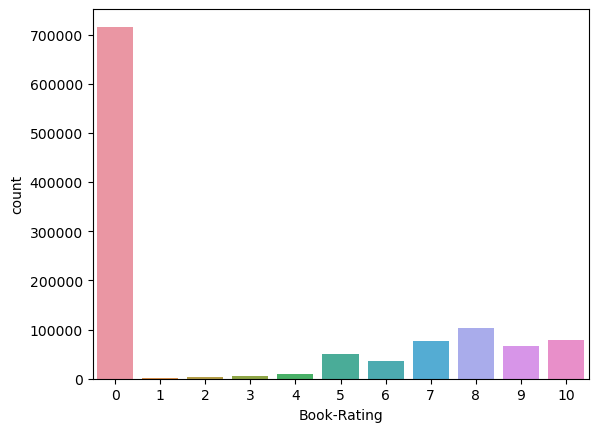

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=ratings['Book-Rating'])

Be aware that interaction with a book is represented as a rating of zero, while ratings between 1 and 10 are real ratings.


Do these ratings correspond to the data we have in the books and users DataFrames? We can compare the number of unique User-ID and ISBN entries in ratings to the number of rows in these DataFrames as a quick check:

In [ ]:
print(len(ratings['User-ID'].unique()))
print(len(ratings['ISBN'].unique()))

105283
340556


Interestingly, there are fewer unique users in ratings compared to users (105,283 versus 278,858) but more unique ISBNs compared to books (340,556 versus 271,379). This means that our database is missing a lot of values, so we will need to be careful when joining tables.

Let’s finish by plotting the number of books that have been rated only once, twice, and so on.

First, we calculate the number of times each `ISBN` appears in the `ratings` DataFrame using the `groupby()` and `size()` functions:

Text(0, 0.5, 'Count')

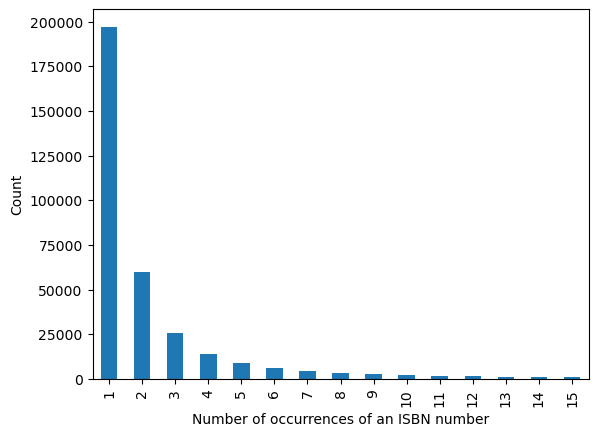

In [ ]:
isbn_counts = ratings.groupby('ISBN').size()
# This creates a new DataFrame, isbn_counts, which contains the count of each unique ISBN in the ratings DataFrame.


# We calculate the number of occurrences of each count value using the value_counts() function. This new DataFrame will contain the count of occurrences of each count value in isbn_counts:
count_occurrences = isbn_counts.value_counts()

# we can plot the distribution, we will only plot the first 15 values:
count_occurrences[:15].plot(kind='bar')
plt.xlabel("Number of occurrences of an ISBN number")
plt.ylabel("Count")

We see that a lot of books have only been rated once or twice. It is very rare to see books with a lot of ratings, which makes things more difficult for us since we rely on these connections.

We repeat the same process to obtain the distribution of the number of times each user (`UserID`) appears in `ratings`:

Text(0, 0.5, 'Count')

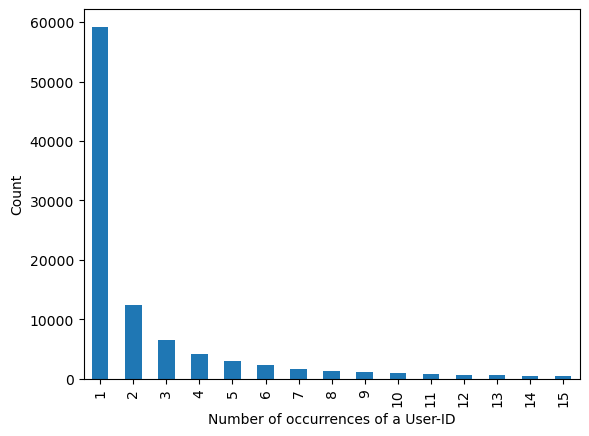

In [ ]:
userid_counts = ratings.groupby('User-ID').size()
count_occurrences = userid_counts.value_counts()
count_occurrences[:15].plot(kind='bar')
plt.xlabel("Number of occurrences of a User-ID")
plt.ylabel("Count")

We obtain a similar distribution.

**This also means that most users only rate one or two books, but a few of them rate a lot of books.**

There are different issues with this dataset, such as mistakes in the year of publication or the name of the publishers, and other missing or incorrect values. However, we will not directly use metadata from the books and users DataFrames in this example. We will rely on the connections between `User-ID` and `ISBN` values, which is why we don’t need to clean the dataset here.

## Preprocessing the Book-Crossing dataset

We want to process the dataset for a particular task: recommending items, and more specifically using a collaborative filtering approach. Collaborative filtering is a technique used to make personalized recommendations to users. It is based on the idea that users who have similar preferences or behaviors are more likely to have similar interests. Collaborative filtering algorithms use this information to identify patterns and make recommendations to users based on the preferences of similar users.

This is different from content-based filtering, which is a recommendation approach that relies on the features of the items being recommended. It generates recommendations by identifying the characteristics of an item and matching them to the characteristics of other items that have been liked by the user in the past. Content-based filtering approaches are typically based on the idea that if a user likes an item with certain characteristics, they will also like items with similar characteristics.


We will focus on **collaborative filtering**. Our objective is to determine which book to recommend to a user based on the preferences of other users. This problem can be represented as a bipartite graph as in the following figure.

![image.png](attachment:image.png)



Knowing that user 1 liked items A and B, and user 3 liked items B and D, we should probably recommend item B to user 2, who also enjoyed items A and D.


This is the type of graph we want to build from the `Book-Crossing dataset`. More precisely, we also want to include negative samples. In this context, negative samples refer to items that have not been rated by a given user. Items that have been rated by a particular user are also referred to as positive items. We will explain why we use this negative sampling technique when we implement the loss function.

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch import nn, optim, Tensor

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn import LGConv

In [ ]:
# We re-load the datasets:
df = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding='latin-1')
users = pd.read_csv('BX-Users.csv', sep=';', encoding='latin-1')
books = pd.read_csv('BX-Books.csv', sep=';', encoding='latin-1', on_bad_lines='skip')#on_bad_lines='error' ) #error_bad_lines=False


# Preprocessing
# We only keep rows where ISBN information can be found in the books DataFrame and User-ID information can be found in the users DataFrame:
df = df.loc[df['ISBN'].isin(books['ISBN'].unique()) & df['User-ID'].isin(users['User-ID'].unique())]

# Keep the 100k highest ratings
# We only keep high ratings (>= 8/10) so the connections we create correspond to books that were liked by users.
# Then, we filter out even more samples and keep a limited number of rows (100,000) to speed up training:
df = df[df['Book-Rating'] >= 8].iloc[:100000]



In [12]:
df = pd.read_csv('data_agg_30Min_with_subgroup.csv', index_col=0)
df.columns

Index(['ind', 'posture', 'x', 'y', 'speed', 'traitement', 'breed',
       'temperature', 'time', '200002', '200004', '200011', '200013', '200014',
       '204926', '204927', '204938', '204945', '204946', 'num_nb', 'degree',
       'close', 'bet', 'pr', 'bet<0.01', '204927==False AND bet<0.01',
       '200002==False AND bet<0.01', '200004==False AND bet<0.01',
       'ind==204945', 'breed==1.0 AND traitement==0.0',
       '200014==True AND traitement==0.0', '200004==True AND traitement==0.0',
       'close>=0.82 AND traitement==0.0', 'num_nb>=7.0 AND traitement==0.0',
       'traitement==1.0 AND y: [34.22:53.93[', 'y: [34.22:53.93[',
       'temperature: [29.0:29.50[ AND y: [34.22:53.93[',
       'ind==204927 AND y: [34.22:53.93[',
       'speed: [3.95:6.97[ AND y: [34.22:53.93[', 'speed>=18.31',
       '204926==True AND speed>=18.31', '200014==True AND speed>=18.31',
       'speed>=18.31 AND traitement==1.0', '200004==False AND speed>=18.31',
       '200004==False AND 204946==True', '2

We create mappings from user and item identifiers to integer indices:

In [13]:
# Create mappings
user_mapping = {userid: i for i, userid in enumerate(df['ind'].unique())}
item_mapping = {isbn: i for i, isbn in enumerate(df['ind'].unique())}

# Count users and items
num_users = len(user_mapping)
num_items = len(item_mapping)
num_total = num_users + num_items

print("num_users : ", num_users)
print("num_items : ", num_items)
print("num_total : ", num_total)

print(user_mapping)

num_users :  10
num_items :  10
num_total :  20
{200002: 0, 200004: 1, 200011: 2, 200013: 3, 200014: 4, 204926: 5, 204927: 6, 204938: 7, 204945: 8, 204946: 9}


We create a tensor of user and item indices based on the user ratings in the dataset. The edge_index tensor is created by stacking these two tensors:

In [14]:
# Build the adjacency matrix based on user ratings
user_ids = torch.LongTensor([user_mapping[i] for i in df['ind']])
item_ids = torch.LongTensor([item_mapping[i] for i in df['ind']])
edge_index = torch.stack((user_ids, item_ids))

In [15]:
edge_index

tensor([[0, 0, 0,  ..., 9, 9, 9],
        [0, 0, 0,  ..., 9, 9, 9]])

We split edge_index into training, validation, and test sets using the train_test_split() function from scikit-learn:

In [16]:
# Create training, validation, and test adjacency matrices
train_index, test_index = train_test_split(range(len(df)), test_size=0.2, random_state=0)
val_index, test_index = train_test_split(test_index, test_size=0.5, random_state=0)

train_edge_index = edge_index[:, train_index]
val_edge_index = edge_index[:, val_index]
test_edge_index = edge_index[:, test_index]

We generate a batch of random indices using the `np.random.choice()` function. This generates `BATCH_SIZE` random indices from a range of `0` to` edge_index.shape[1]-1`. These indices will be used to select rows from the edge_index tensor.

We generate negative samples using the `structured_negative_sampling()` function from PyTorch Geometric. Negative samples are items with which the corresponding user has not interacted. We use the `torch.stack()` function to add a dimension at the beginning.


We select the user, positive item, and negative item indices for the batch using the index array and the `edge_index` tensor.

In [17]:
def sample_mini_batch(edge_index):
    # Generate BATCH_SIZE random indices
    index = np.random.choice(range(edge_index.shape[1]), size=BATCH_SIZE)

    # Generate negative sample indices
    edge_index = structured_negative_sampling(edge_index)
    edge_index = torch.stack(edge_index, dim=0)

    user_index = edge_index[0, index]
    pos_item_index = edge_index[1, index]
    neg_item_index = edge_index[2, index]

    return user_index, pos_item_index, neg_item_index

The `user_index` tensor contains the user indices for the batch, the `pos_item_index` tensor contains the positive item indices for the batch, and the `neg_item_index` tensor contains the negative item indices for the batch.

## Implementing the LightGCN architecture


X. He, K. Deng, X. Wang, Y. Li, Y. Zhang, and M. Wang, LightGCN: Simplifying and Powering Graph Convolution Network for Recommendation. arXiv, 2020. doi: 10.48550/ARXIV.2002.02126. Available: https://arxiv.org/abs/2002.02126

The LightGCN  architecture aims to learn representations for nodes by smoothing features over the graph. It iteratively performs graph convolution, where neighboring nodes’ features are aggregated as the new representation of a target node.



![image.png](attachment:image.png)



However, LightGCN adopts a simple weighted sum aggregator rather than using feature transformation or nonlinear activation as seen in other models such as the GCN or GAT.
The light graph convolution  operation calculates the k+1-th user and item embedding $e_u^{k+1}$ and $e_i^{k+1}$ as follows:

![image-2.png](attachment:image-2.png)

![image-3.png](attachment:image-3.png)



The symmetric normalization term ensures that the scale of embeddings does not increase with graph convolution operations. In contrast to other models, LightGCN only aggregates the connected neighbors and **does not include self-connections**.

Indeed, it achieves the same effect by using a layer combination operation. This mechanism consists of a weighted sum using user and item embeddings at each layer. It produces the final embeddings  $e_u$ and $e_i$ with the following equations:


![image-4.png](attachment:image-4.png)



Here, the contribution of k-th layer is weighted by the variable $\alpha_k\geq 0$. The authors recommend setting it to $\frac{1}{K+1}$.

The prediction corresponds to ratings or ranking scores. It is obtained using the inner product of user and item final representations:

$$\hat{y}_{ui}= e^\top_u e_i$$

Let’s now implement this architecture in PyTorch Geometric:

We create a `LightGCN` class with four arguments: `num_users, num_items, num_layers`, and `dim_h`. The `num_users` and `num_items `arguments specify the number of users and items in the dataset, respectively. `num_layers` indicates the number of LightGCN layers that will be used, and the `dim_h` argument specifies the size of the embedding vectors (for the users and items):

In [18]:
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, num_layers=4, dim_h=64):
        super().__init__()

        #  We store the number of users and items and create user and item embedding layers.
        # The shape of the emb_users ($e_u^0$) is (num_users, dim_h) and the shape of the emb_items ($e_i^0$)  is (num_items, dim_h)
        self.num_users = num_users
        self.num_items = num_items
        self.num_layers = num_layers
        self.emb_users = nn.Embedding(num_embeddings=self.num_users, embedding_dim=dim_h)
        self.emb_items = nn.Embedding(num_embeddings=self.num_items, embedding_dim=dim_h)

        # We create a list of num_layers (previously called K) LightGCN layers using PyTorch Geometric’s LGConv().
        # This will be used to perform the light graph convolution operations:
        self.convs = nn.ModuleList(LGConv() for _ in range(num_layers))

        # We initialize the user and item embedding layers with normal distributions with a standard deviation of 0.01.
        # This helps to prevent the model from getting stuck in poor local optima when it is trained:
        nn.init.normal_(self.emb_users.weight, std=0.01)
        nn.init.normal_(self.emb_items.weight, std=0.01)


    # The forward() method takes in an edge index tensor and returns the final user and item embedding vectors, e_u^(K) and e_i^(K).
    # It starts by concatenating the user and item embedding layers and storing the result in the emb tensor. It then creates a list, **embs**, with emb as its first element:

    def forward(self, edge_index):
        emb = torch.cat([self.emb_users.weight, self.emb_items.weight])
        embs = [emb]

        # We then apply the LightGCN layers in a loop and store the output of each layer in the embs list:
        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        # We perform layer combination by calculating the final embedding vectors by taking the mean of the tensors in the embs list along the second dimension:
        emb_final = 1/(self.num_layers+1) * torch.mean(torch.stack(embs, dim=1), dim=1)

        # We split emb_final into user e_u and item e_i embedding vectors
        emb_users_final, emb_items_final = torch.split(emb_final, [self.num_users, self.num_items])

        return emb_users_final, self.emb_users.weight, emb_items_final, self.emb_items.weight

Before we can train the model, we need a loss function. The LightGCN architecture employs Bayesian Personalized Ranking (BPR) loss, which optimizes the model’s ability to rank positive items higher than negative items for a given user.

It is implemented as follows:  

![image.png](attachment:image.png)


Here, $E^{(0)}$ is the 0th-layer embedding  matrix (concatenation of the initial user and item embeddings), λ weighs the regularization strength, $ \hat{y}_{ui}$ corresponds to the predicted rating of a positive item, and $ \hat{y}_{uj}$ represents the predicted rating of a negative item.

We implement it in PyTorch with the following function:

In [19]:
def bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items):
    reg_loss = LAMBDA * (emb_users.norm().pow(2) +
                        emb_pos_items.norm().pow(2) +
                        emb_neg_items.norm().pow(2))

    pos_ratings = torch.mul(emb_users_final, emb_pos_items_final).sum(dim=-1)
    neg_ratings = torch.mul(emb_users_final, emb_neg_items_final).sum(dim=-1)

    bpr_loss = torch.mean(torch.nn.functional.softplus(pos_ratings - neg_ratings))
    # bpr_loss = torch.mean(torch.nn.functional.logsigmoid(pos_ratings - neg_ratings))

    return -bpr_loss + reg_loss

On top of the BPR loss, we use two metrics to evaluate the performance of our model:

* Recall@k is the proportion of relevant recommended items in top k among all possible relevant items. However, this metric does not consider the order of relevant items in top k:
* Normalized Discounted Cumulative Gain (NDGC) measures the effectiveness of the system’s ranking of the recommendations, taking into account the relevance of the items, where relevance is usually represented by a score or a binary relevance (relevant or not).

In [20]:
def get_user_items(edge_index):
    user_items = dict()
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_items:
            user_items[user] = []
        user_items[user].append(item)
    return user_items

In [21]:
def compute_recall_at_k(items_ground_truth, items_predicted):
    num_correct_pred = np.sum(items_predicted, axis=1)
    num_total_pred = np.array([len(items_ground_truth[i]) for i in range(len(items_ground_truth))])

    recall = np.mean(num_correct_pred / num_total_pred)

    return recall

In [22]:
def compute_ndcg_at_k(items_ground_truth, items_predicted):
    test_matrix = np.zeros((len(items_predicted), K))

    for i, items in enumerate(items_ground_truth):
        length = min(len(items), K)
        test_matrix[i, :length] = 1

    max_r = test_matrix
    idcg = np.sum(max_r * 1. / np.log2(np.arange(2, K + 2)), axis=1)
    dcg = items_predicted * (1. / np.log2(np.arange(2, K + 2)))
    dcg = np.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[np.isnan(ndcg)] = 0.

    return np.mean(ndcg)

In [23]:
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices):

    ratings = torch.matmul(model.emb_users.weight, model.emb_items.weight.T)

    for exclude_edge_index in exclude_edge_indices:
        user_pos_items = get_user_items(exclude_edge_index)
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
        ratings[exclude_users, exclude_items] = -1024

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(ratings, k=K)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    items_predicted = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        items_predicted.append(label)

    recall = compute_recall_at_k(test_user_pos_items_list, items_predicted)
    ndcg = compute_ndcg_at_k(test_user_pos_items_list, items_predicted)

    return recall, ndcg

In [24]:
# wrapper function to evaluate model
def test(model, edge_index, exclude_edge_indices):
    emb_users_final, emb_users, emb_items_final, emb_items = model.forward(edge_index)
    user_indices, pos_item_indices, neg_item_indices = structured_negative_sampling(edge_index, contains_neg_self_loops=False)

    emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]

    emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
    emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

    loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items).item()

    recall, ndcg = get_metrics(model, edge_index, exclude_edge_indices)

    return loss, recall, ndcg

We can now create a training loop and start training the LightGCN model:

In [28]:
K = 5
LAMBDA = 1e-6
BATCH_SIZE = 1024

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LightGCN(num_users, num_items)
model = model.to(device)
edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
%%time

n_batch = int(len(train_index)/BATCH_SIZE)

for epoch in range(31):
    model.train()

    for _ in range(n_batch):
        optimizer.zero_grad()

        emb_users_final, emb_users, emb_items_final, emb_items = model.forward(train_edge_index)

        user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(train_edge_index)

        emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]
        emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
        emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

        train_loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items)

        train_loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        model.eval()
        val_loss, recall, ndcg = test(model, val_edge_index, [train_edge_index])
        print(f"Epoch {epoch} | Train loss: {train_loss.item():.5f} | Val loss: {val_loss:.5f} | Val recall@{K}: {recall:.5f} | Val ndcg@{K}: {ndcg:.5f}")

Epoch 0 | Train loss: -0.69322 | Val loss: -0.69271 | Val recall@5: 0.00000 | Val ndcg@5: 0.00000
Epoch 5 | Train loss: -0.70073 | Val loss: -0.64945 | Val recall@5: 0.00000 | Val ndcg@5: 0.00000
Epoch 10 | Train loss: -0.72748 | Val loss: -0.51467 | Val recall@5: 0.00000 | Val ndcg@5: 0.00000
Epoch 15 | Train loss: -0.78691 | Val loss: -0.27779 | Val recall@5: 0.00000 | Val ndcg@5: 0.00000
Epoch 20 | Train loss: -0.90713 | Val loss: 0.06546 | Val recall@5: 0.00000 | Val ndcg@5: 0.00000
Epoch 25 | Train loss: -1.11787 | Val loss: 0.48595 | Val recall@5: 0.00000 | Val ndcg@5: 0.00000
Epoch 30 | Train loss: -1.44537 | Val loss: 0.94618 | Val recall@5: 0.00000 | Val ndcg@5: 0.00000
CPU times: user 27.9 s, sys: 125 ms, total: 28 s
Wall time: 29 s


In [32]:
test_loss, test_recall, test_ndcg = test(model, test_edge_index.to(device), [train_edge_index, val_edge_index])

print(f"Test loss: {test_loss:.5f} | Test recall@{K}: {test_recall:.5f} | Test ndcg@{K}: {test_ndcg:.5f}")

Test loss: 0.94610 | Test recall@5: 0.00000 | Test ndcg@5: 0.00000


## Recommending books for a particular user

Now that the model is trained, we want to get recommendations for a given user. The recommendation function we want to create has two components:

* First, we want to retrieve a list of books the user liked. This will help us to contextualize the recommendations for our own understanding.
* Secondly, we want to generate a list of recommendations. These recommendations cannot be books the user has already rated (it cannot be a positive item).

In [ ]:
bookid_title = pd.Series(books['Book-Title'].values, index=books.ISBN).to_dict()
bookid_author = pd.Series(books['Book-Author'].values, index=books.ISBN).to_dict()
user_pos_items = get_user_items(edge_index)

#print(user_pos_items)

In [ ]:
from PIL import Image
import requests

def recommend(user_id, num_recs):
    user = user_mapping[user_id]
    emb_user = model.emb_users.weight[user]
    ratings = model.emb_items.weight @ emb_user

    values, indices = torch.topk(ratings, k=100)

    ids = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
    item_isbns = [list(item_mapping.keys())[list(item_mapping.values()).index(book)] for book in ids]
    titles = [bookid_title[id] for id in item_isbns]
    authors = [bookid_author[id] for id in item_isbns]

    print(f'Favorite books from user n°{user_id}:')
    for i in range(len(item_isbns)):
        print(f'- {titles[i]}, by {authors[i]}')

    ids = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
    item_isbns = [list(item_mapping.keys())[list(item_mapping.values()).index(book)] for book in ids]
    titles = [bookid_title[id] for id in item_isbns]
    authors = [bookid_author[id] for id in item_isbns]

    print(f'\nRecommended books for user n°{user_id}')
    for i in range(num_recs):
        print(f'- {titles[i]}, by {authors[i]}')

    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    fig, axs = plt.subplots(1, num_recs, figsize=(20,6))
    fig.patch.set_alpha(0)
    for i, title in enumerate(titles):
        url = books.loc[books['Book-Title'] == title]['Image-URL-L'][:1].values[0]
        img = Image.open(requests.get(url, stream=True, headers=headers).raw)
        rating = df.loc[df['ISBN'] == books.loc[books['Book-Title'] == title]['ISBN'][:1].values[0]]['Book-Rating'].mean()
        axs[i].axis("off")
        axs[i].imshow(img)
        axs[i].set_title(f'{rating:.1f}/10', y=-0.1, fontsize=18)

Favorite books from user n°277427:
- The Da Vinci Code, by Dan Brown
- Into the Wild, by Jon Krakauer
- One for the Money (Stephanie Plum Novels (Paperback)), by Janet Evanovich

Recommended books for user n°277427
- The Lovely Bones: A Novel, by Alice Sebold
- The Red Tent (Bestselling Backlist), by Anita Diamant
- Angels &amp; Demons, by Dan Brown
- Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)), by J. K. Rowling
- To Kill a Mockingbird, by Harper Lee


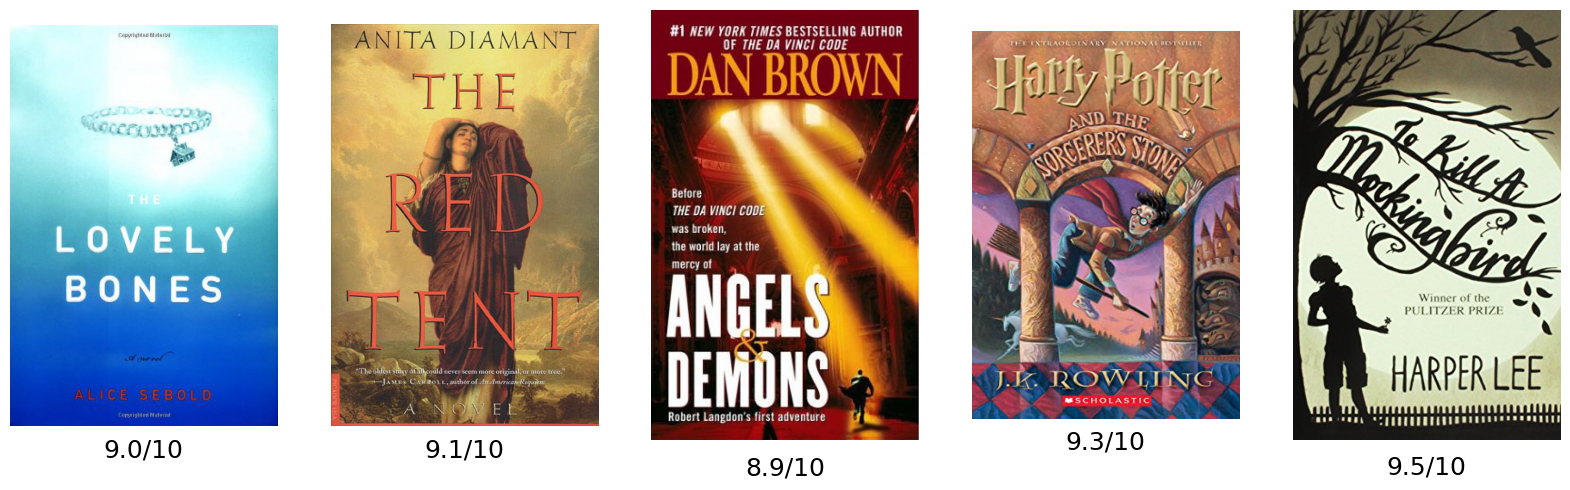

In [ ]:
recommend(277427, 5)

We can now generate recommendations for any user from the original df DataFrame. You can test other IDs and explore how that changes the recommendations.